# RecDP LLM - Toxicity and Bias Control

This component will score text toxicity and bias with pre-trained BERT and Roberta model. User can use that as an indicator to decide if we should skip toxic data.

Return Value: score range from 0 - 1. Higher is more toxic

# Get Started

1.Install pyrecdp and dependencies

In [ ]:
! DEBIAN_FRONTEND=noninteractive apt-get install -qq -y openjdk-8-jre
! pip install -q pyrecdp --pre
# ! pip install 'git+https://github.com/intel/e2eAIOK.git#egg=pyrecdp&subdirectory=RecDP'

## 2. Prepare your own data

In [ ]:
%mkdir -p /content/test_data
%cd /content/test_data
!wget https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/tiny_c4_sample.jsonl

### 3.1 Process with TextToxicity

In [3]:
from pyrecdp.LLM import TextPipeline, ResumableTextPipeline
from pyrecdp.primitives.operations import *

pipeline = ResumableTextPipeline()
ops = [
    JsonlReader("/content/test_data/"),
    TextToxicity(),
    ParquetWriter("ResumableTextPipeline_output")
]
pipeline.add_operations(ops)
ret = pipeline.execute()
del pipeline

JAVA_HOME is not set, use default value of /usr/lib/jvm/java-8-openjdk-amd64/


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

init ray with total mem of 8167961395


2023-10-18 19:14:34,672	WARNING services.py:1889 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 6133116928 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=8.37gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-10-18 19:14:35,779	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-18 19:14:38,272	INFO read_api.py:406 -- To satisfy the requested parallelism of 2, each read task output is split into 2 smaller blocks.
ResumableTextPipeline, current on tiny_c4_sample.jsonl:   0%|          | 0/1 [00:00<?, ?it/s]Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt" to /root/.cache/torch/hub/checkpoints/multilingual_debiased-0b549669.ckpt



2023-10-18 19:15:01,307	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadText->SplitBlocks(2)] -> TaskPoolMapOperator[Map(<lambda>)->Map(<lambda>)->Filter(<lambda>)->Write]
2023-10-18 19:15:01,309	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-18 19:15:01,314	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(Map(<lambda>)->Map(<lambda>)->Filter(<lambda>)->Write pid=2004) 2023-10-18 19:15:22.679008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ResumableTextPipeline, current on tiny_c4_sample.jsonl: 100%|██████████| 1/1 [11:48<00:00, 708.69s/it]

2023-10-18 19:26:26.999 | INFO     | pyrecdp.LLM.TextPipeline:execute:325 - Completed! ResumableTextPipeline will not return dataset, please check ResumableTextPipeline_output for verification.


### 3.2 View processed data

In [4]:
import pandas as pd
toxicity_score_pd = pd.read_parquet("ResumableTextPipeline_output/tiny_c4_sample.jsonl")
toxicity_score_pd.head()

,text,meta,source_id,text_toxicity
0,lorazepam nombre comercial mexico From an inte...,"{""timestamp"":""2019-04-24T02:17:53Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000705
1,It is possible to love someone who does not lo...,"{""timestamp"":""2019-04-23T06:32:35Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.001997
2,Canon PIXMA TS9520 All-in-One Print / Scan / C...,"{""timestamp"":""2019-04-25T17:03:36Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000539
3,For those who plan on buying an iPad this Satu...,"{""timestamp"":""2019-04-22T22:39:52Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000372
4,"After tipping 25 tokens in a day, you'll be ab...","{""timestamp"":""2019-04-20T00:25:13Z"",""url"":""htt...",tiny_c4_sample.jsonl,0.000326


### 3.3 validate with google perspectiveAPI for cross examination

To use perspectiveAPI, user need to provide their google api token
You can refer to [Request access to Perspective API](https://support.perspectiveapi.com/s/docs-get-started?language=en_US) to request access and refer to [Generate Credentials API token](https://support.perspectiveapi.com/s/docs-enable-the-api?language=en_US) to generate api_key and put it here.

In [ ]:
api_key = "" #input your api_key here

In [ ]:
!pip install perspective
from perspective import PerspectiveAPI

def prepare_func_text_toxicity_perspective(api_key):
    p = PerspectiveAPI(api_key)
    def generate_toxicity_label(content):
        result = p.score(content)
        return float(result["TOXICITY"])

    return generate_toxicity_label

import pyspark.sql.functions as F
from pyrecdp.core import SparkDataProcessor
data_file = "ResumableTextPipeline_output/tiny_c4_sample.jsonl"
save_path = '/content/test_data/output/toxicity_score'

rdp = SparkDataProcessor()
toxicity_score_spark_df = rdp.spark.read.json(data_file)
func = F.udf(prepare_func_text_toxicity_perspective(api_key))
toxicity_score_persepectiveAPI_spark_df = toxicity_score_spark_df.withColumn("text_toxicity_perspectiveAPI", func(F.col("text")))

toxicity_score_persepectiveAPI_spark_df.show()

+--------------------+--------------------+--------------------+----------------------------+
|                meta|                text|       text_toxicity|text_toxicity_perspectiveAPI|
+--------------------+--------------------+--------------------+----------------------------+
|{"timestamp":"201...|lorazepam nombre ...|7.045677630230784E-4|                 0.035220183|
|{"timestamp":"201...|It is possible to...|0.001997147919610...|                 0.069754265|
|{"timestamp":"201...|Canon PIXMA TS952...|5.388619028963149E-4|                 0.008419261|
|{"timestamp":"201...|For those who pla...|3.720709937624633...|                 0.112540044|
|{"timestamp":"201...|After tipping 25 ...|3.255245683249086E-4|                 0.013257195|
|{"timestamp":"201...|When cute redhead...| 0.02352582849562168|                  0.36095104|
|{"timestamp":"201...|Description: Deco...| 0.25577104091644287|                   0.3389984|
|{"timestamp":"201...|Download BustedBo...|2.149254432879388

### 3.4 Visualization, comparing the toxicity score between detoxify and perspectiveAPI.

In [ ]:
toxicity_score_pd = toxicity_score_persepectiveAPI_spark_df.limit(20).toPandas()

<Axes: title={'center': 'Quality score of datasets'}>

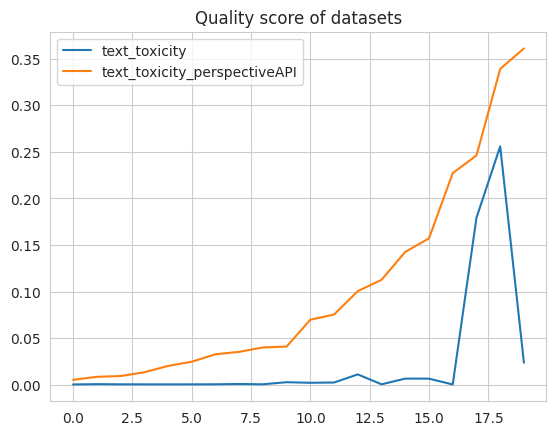

In [ ]:
import pandas as pd
toxicity_score_pd["text_toxicity"] = pd.to_numeric(toxicity_score_pd["text_toxicity"])
toxicity_score_pd["text_toxicity_perspectiveAPI"] = pd.to_numeric(toxicity_score_pd["text_toxicity_perspectiveAPI"])
toxicity_score_pd.sort_values(by=["text_toxicity_perspectiveAPI"]).reset_index().plot(y=["text_toxicity", "text_toxicity_perspectiveAPI"], kind="line", title="Quality score of datasets")

## 4. comparing profanity_check vs Toxicity check

In [ ]:
from profanity_check import predict_prob
def prepare_func_profanity_score(content):
  scores = predict_prob([content])
  return float(scores[0])

import pyspark.sql.functions as F
func = F.udf(prepare_func_profanity_score)
profanity_score_spark_df = toxicity_score_spark_df.withColumn("text_profanity_score", func(F.col("text")))
profanity_score_spark_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                meta|                text|       text_toxicity|text_profanity_score|
+--------------------+--------------------+--------------------+--------------------+
|{"timestamp":"201...|lorazepam nombre ...|7.045677630230784E-4|0.040039424167676106|
|{"timestamp":"201...|It is possible to...|0.001997147919610...|0.028989691808218948|
|{"timestamp":"201...|Canon PIXMA TS952...|5.388619028963149E-4|   0.043861183352844|
|{"timestamp":"201...|For those who pla...|3.720709937624633...|0.004377341418335424|
|{"timestamp":"201...|After tipping 25 ...|3.255245683249086E-4|0.009099317732054453|
|{"timestamp":"201...|When cute redhead...| 0.02352582849562168| 0.04230116186167876|
|{"timestamp":"201...|Description: Deco...| 0.25577104091644287| 0.09813155457491825|
|{"timestamp":"201...|Download BustedBo...|2.149254432879388...|0.014691897752754538|
|{"timestamp":"201...|Judah Ben-Hur liv...|0.006481378

In [ ]:
profanity_score_spark_df.filter("text_profanity_score > 0.1").show()

+--------------------+--------------------+--------------------+--------------------+
|                meta|                text|       text_toxicity|text_profanity_score|
+--------------------+--------------------+--------------------+--------------------+
|{"timestamp":"201...|It’s Day 11, and ...|0.011020174250006676|  0.1075886803904289|
|{"timestamp":"201...|wing back chair c...|0.004366231616586447|  0.2310903976563441|
|{"timestamp":"201...|A flirty flared t...|0.011921738274395466|    0.16461638282759|
|{"timestamp":"201...|House for a trip ...|0.006529421545565128| 0.19788234991696743|
|{"timestamp":"201...|Today, there is a...|  0.4169255197048187| 0.13755844069518922|
|{"timestamp":"201...|Starring Yasmine ...| 0.21636812388896942|  0.3046393001622488|
|{"timestamp":"201...|What is this hot ...| 0.18693310022354126| 0.15193193949897144|
|{"timestamp":"201...|Upload a picture ...| 0.25675785541534424| 0.16366510186922595|
|{"timestamp":"201...|Naughty office 3....|6.181608769